In [2]:
import math
import torch.nn as nn
import torch
import torch.nn.functional as F 

class MLP(nn.Module):
    def __init__(self, in_features, out_features):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.1),  # 30% нейронов отключаются во время обучения

            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(128, out_features)  # Выходной слой
        )

    def forward(self, x):
        return self.model(x)



In [3]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from utility import CustomHeteroGraphDataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from utility import prepare_scalers
from sklearn.preprocessing import MinMaxScaler

src = "data/data_sioux.csv"

df = pd.read_csv(src)

indices = list(range(len(df)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

node_scaler, edge_scaler, y_scaler = prepare_scalers(src, train_indices, n_nodes=24, scaler_type=MinMaxScaler)

train_dataset = CustomHeteroGraphDataset(src, train_indices, node_scaler, edge_scaler, y_scaler, 24)
test_dataset = CustomHeteroGraphDataset(src, test_indices, node_scaler, edge_scaler, y_scaler, 24)

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=lambda batch: Batch.from_data_list(batch))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda batch: Batch.from_data_list(batch))


c:\py\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
num_epochs = 40
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(24*24+76*2, 76).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
mae_f = torch.nn.L1Loss()
loss_fn = torch.nn.MSELoss()

train_losses = []
test_losses = []

for epoch in tqdm(range(1, num_epochs + 1)):
    model.train()
    total_train_loss = 0
    total_train_batches = 0

    for i, data in enumerate(train_loader): 
        data = data.to(device)
        optimizer.zero_grad()
        vec = torch.cat((data['real'].x.view(-1), data['real'].edge_attr[:, 0], data['real'].edge_attr[:, 1]), dim=0)
        pred_alpha = model(vec)
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]
        loss = loss_fn(pred_f, data['real'].y)

        if i == 0:
            print("Sample predictions:")
            print("True flow:", data['real'].y[:5])
            print("Pred flow:", pred_f[:5])

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_batches += 1
        
    avg_train_loss = total_train_loss / total_train_batches
    train_losses.append(avg_train_loss)
    print(f'Epoch {epoch}, avg train Loss: {avg_train_loss:.4f}')


    model.eval()
    total_loss = 0
    total_batches = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            vec = torch.cat((data['real'].x.view(-1), data['real'].edge_attr[:, 0], data['real'].edge_attr[:, 1]), dim=0)
            pred_alpha = model(vec)
            pred_f = pred_alpha * data['real'].edge_attr[:, 1]
            test_loss = loss_fn(pred_f, data['real'].y)
            total_loss += test_loss
            total_batches += 1

    mae_loss = total_loss / total_batches
    test_losses.append(mae_loss)
    print(f'Epoch {epoch}, Test MAE: {mae_loss:.4f}')


  0%|          | 0/40 [00:00<?, ?it/s]

Sample predictions:
True flow: tensor([0.1624, 0.2667, 0.1597, 0.1562, 0.2743], device='cuda:0')
Pred flow: tensor([-0.0177, -0.0277, -0.0028,  0.0005,  0.0015], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 1, avg train Loss: 0.0084


  2%|▎         | 1/40 [01:43<1:07:05, 103.22s/it]

Epoch 1, Test MAE: 0.0075
Sample predictions:
True flow: tensor([0.1651, 0.2579, 0.1528, 0.1429, 0.3012], device='cuda:0')
Pred flow: tensor([0.1649, 0.3116, 0.1851, 0.1784, 0.2188], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 2, avg train Loss: 0.0076


  5%|▌         | 2/40 [03:22<1:03:49, 100.76s/it]

Epoch 2, Test MAE: 0.0075
Sample predictions:
True flow: tensor([0.2170, 0.2286, 0.1157, 0.1852, 0.3239], device='cuda:0')
Pred flow: tensor([0.1266, 0.1829, 0.1625, 0.1790, 0.3535], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 3, avg train Loss: 0.0076


  8%|▊         | 3/40 [05:03<1:02:23, 101.17s/it]

Epoch 3, Test MAE: 0.0075
Sample predictions:
True flow: tensor([0.0866, 0.2446, 0.1136, 0.0954, 0.2416], device='cuda:0')
Pred flow: tensor([0.1411, 0.2491, 0.1236, 0.1721, 0.1820], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 4, avg train Loss: 0.0075


 10%|█         | 4/40 [06:46<1:01:03, 101.75s/it]

Epoch 4, Test MAE: 0.0074
Sample predictions:
True flow: tensor([0.2067, 0.2795, 0.1504, 0.1827, 0.3246], device='cuda:0')
Pred flow: tensor([0.1773, 0.2083, 0.0851, 0.1740, 0.2663], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 5, avg train Loss: 0.0075


 12%|█▎        | 5/40 [08:31<59:57, 102.78s/it]  

Epoch 5, Test MAE: 0.0074
Sample predictions:
True flow: tensor([0.1667, 0.3113, 0.1596, 0.1483, 0.3265], device='cuda:0')
Pred flow: tensor([0.0813, 0.2265, 0.1469, 0.1456, 0.2924], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 6, avg train Loss: 0.0075


 15%|█▌        | 6/40 [10:15<58:27, 103.16s/it]

Epoch 6, Test MAE: 0.0074
Sample predictions:
True flow: tensor([0.1177, 0.2079, 0.1184, 0.1367, 0.2643], device='cuda:0')
Pred flow: tensor([0.1128, 0.2894, 0.1252, 0.1556, 0.2416], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 7, avg train Loss: 0.0075


 18%|█▊        | 7/40 [11:56<56:21, 102.47s/it]

Epoch 7, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.1152, 0.3070, 0.1692, 0.1014, 0.2378], device='cuda:0')
Pred flow: tensor([0.1588, 0.2665, 0.1292, 0.0698, 0.2390], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 8, avg train Loss: 0.0074


 20%|██        | 8/40 [13:34<53:59, 101.23s/it]

Epoch 8, Test MAE: 0.0074
Sample predictions:
True flow: tensor([0.0862, 0.3349, 0.2275, 0.0500, 0.2530], device='cuda:0')
Pred flow: tensor([0.0871, 0.2266, 0.1327, 0.1030, 0.2485], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 9, avg train Loss: 0.0074


 22%|██▎       | 9/40 [15:15<52:10, 100.98s/it]

Epoch 9, Test MAE: 0.0074
Sample predictions:
True flow: tensor([0.1340, 0.3414, 0.2166, 0.1103, 0.2582], device='cuda:0')
Pred flow: tensor([0.1021, 0.3289, 0.1405, 0.0834, 0.2477], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 10, avg train Loss: 0.0074


 25%|██▌       | 10/40 [16:55<50:21, 100.71s/it]

Epoch 10, Test MAE: 0.0074
Sample predictions:
True flow: tensor([0.1291, 0.3036, 0.1621, 0.1100, 0.2442], device='cuda:0')
Pred flow: tensor([0.0971, 0.3641, 0.1042, 0.1450, 0.3332], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 11, avg train Loss: 0.0074


 28%|██▊       | 11/40 [18:34<48:26, 100.23s/it]

Epoch 11, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.1091, 0.3005, 0.1858, 0.0776, 0.2622], device='cuda:0')
Pred flow: tensor([0.1491, 0.1711, 0.1273, 0.0366, 0.3232], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 12, avg train Loss: 0.0074


 30%|███       | 12/40 [20:15<46:50, 100.39s/it]

Epoch 12, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.1216, 0.2822, 0.1353, 0.1308, 0.2367], device='cuda:0')
Pred flow: tensor([0.0949, 0.2935, 0.1385, 0.0691, 0.2498], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 13, avg train Loss: 0.0074


 32%|███▎      | 13/40 [21:55<45:12, 100.48s/it]

Epoch 13, Test MAE: 0.0074
Sample predictions:
True flow: tensor([0.1021, 0.3337, 0.1935, 0.0654, 0.2269], device='cuda:0')
Pred flow: tensor([0.1498, 0.1696, 0.1702, 0.0192, 0.1733], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 14, avg train Loss: 0.0074


 35%|███▌      | 14/40 [23:39<43:54, 101.31s/it]

Epoch 14, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.1712, 0.1971, 0.0651, 0.1319, 0.3045], device='cuda:0')
Pred flow: tensor([0.1379, 0.2395, 0.0918, 0.0790, 0.2621], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 15, avg train Loss: 0.0074


 38%|███▊      | 15/40 [25:18<41:58, 100.74s/it]

Epoch 15, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.0943, 0.2429, 0.1156, 0.0814, 0.1947], device='cuda:0')
Pred flow: tensor([0.1362, 0.3073, 0.1540, 0.0212, 0.3524], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 16, avg train Loss: 0.0074


 40%|████      | 16/40 [27:00<40:24, 101.03s/it]

Epoch 16, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.1898, 0.2538, 0.1211, 0.1519, 0.3125], device='cuda:0')
Pred flow: tensor([0.1393, 0.2122, 0.1568, 0.0943, 0.2813], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 17, avg train Loss: 0.0074


 42%|████▎     | 17/40 [28:31<37:38, 98.18s/it] 

Epoch 17, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.1632, 0.2270, 0.1409, 0.1265, 0.2751], device='cuda:0')
Pred flow: tensor([0.1294, 0.2003, 0.1506, 0.1664, 0.3392], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 18, avg train Loss: 0.0074


 45%|████▌     | 18/40 [30:03<35:19, 96.34s/it]

Epoch 18, Test MAE: 0.0074
Sample predictions:
True flow: tensor([0.1523, 0.3215, 0.1776, 0.1363, 0.2736], device='cuda:0')
Pred flow: tensor([0.1038, 0.2280, 0.1642, 0.1471, 0.2715], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 19, avg train Loss: 0.0074


 48%|████▊     | 19/40 [31:36<33:20, 95.26s/it]

Epoch 19, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.1961, 0.2604, 0.1624, 0.1641, 0.3067], device='cuda:0')
Pred flow: tensor([0.1610, 0.2816, 0.1115, 0.1242, 0.2122], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 20, avg train Loss: 0.0074


 50%|█████     | 20/40 [33:08<31:24, 94.23s/it]

Epoch 20, Test MAE: 0.0074
Sample predictions:
True flow: tensor([0.1508, 0.2908, 0.1493, 0.1354, 0.2963], device='cuda:0')
Pred flow: tensor([0.1147, 0.2287, 0.1304, 0.1187, 0.1630], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 21, avg train Loss: 0.0074


 52%|█████▎    | 21/40 [34:39<29:32, 93.29s/it]

Epoch 21, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.1192, 0.2018, 0.0988, 0.0958, 0.2500], device='cuda:0')
Pred flow: tensor([0.0922, 0.1910, 0.1457, 0.1313, 0.3090], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 22, avg train Loss: 0.0074


 55%|█████▌    | 22/40 [36:11<27:52, 92.90s/it]

Epoch 22, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.2083, 0.1748, 0.0755, 0.1659, 0.3396], device='cuda:0')
Pred flow: tensor([0.1160, 0.3114, 0.1151, 0.1595, 0.3360], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 23, avg train Loss: 0.0074


 57%|█████▊    | 23/40 [37:43<26:16, 92.76s/it]

Epoch 23, Test MAE: 0.0074
Sample predictions:
True flow: tensor([0.1570, 0.1936, 0.1316, 0.1462, 0.2771], device='cuda:0')
Pred flow: tensor([0.1440, 0.1683, 0.1744, 0.1097, 0.2831], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 24, avg train Loss: 0.0074


 60%|██████    | 24/40 [39:18<24:51, 93.19s/it]

Epoch 24, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.1537, 0.2724, 0.1668, 0.1391, 0.2799], device='cuda:0')
Pred flow: tensor([0.1402, 0.2019, 0.0829, 0.0973, 0.1879], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 25, avg train Loss: 0.0074


 62%|██████▎   | 25/40 [40:50<23:16, 93.08s/it]

Epoch 25, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.1455, 0.2348, 0.1124, 0.1364, 0.2708], device='cuda:0')
Pred flow: tensor([0.0991, 0.3287, 0.1446, 0.1502, 0.2057], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 26, avg train Loss: 0.0074


 65%|██████▌   | 26/40 [42:22<21:38, 92.74s/it]

Epoch 26, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.0987, 0.2683, 0.1369, 0.0786, 0.1884], device='cuda:0')
Pred flow: tensor([0.1693, 0.2696, 0.1050, 0.0667, 0.3291], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 27, avg train Loss: 0.0074


 68%|██████▊   | 27/40 [43:54<20:01, 92.42s/it]

Epoch 27, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.1822, 0.2082, 0.0989, 0.1679, 0.3147], device='cuda:0')
Pred flow: tensor([0.1351, 0.2821, 0.1392, 0.0582, 0.2809], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 28, avg train Loss: 0.0074


 70%|███████   | 28/40 [45:26<18:29, 92.43s/it]

Epoch 28, Test MAE: 0.0074
Sample predictions:
True flow: tensor([0.1625, 0.2337, 0.1114, 0.1515, 0.3068], device='cuda:0')
Pred flow: tensor([0.1341, 0.2360, 0.1513, 0.1013, 0.3142], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 29, avg train Loss: 0.0073


 72%|███████▎  | 29/40 [46:58<16:53, 92.11s/it]

Epoch 29, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.0850, 0.3215, 0.1620, 0.0799, 0.1973], device='cuda:0')
Pred flow: tensor([0.1044, 0.2500, 0.0891, 0.0189, 0.2872], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 30, avg train Loss: 0.0073


 75%|███████▌  | 30/40 [48:30<15:20, 92.05s/it]

Epoch 30, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.1218, 0.2462, 0.1106, 0.0930, 0.2643], device='cuda:0')
Pred flow: tensor([0.1542, 0.2028, 0.1361, 0.0267, 0.2246], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 31, avg train Loss: 0.0073


 78%|███████▊  | 31/40 [50:02<13:48, 92.06s/it]

Epoch 31, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.1176, 0.2814, 0.1653, 0.0906, 0.2349], device='cuda:0')
Pred flow: tensor([0.0928, 0.3424, 0.1056, 0.1412, 0.3389], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 32, avg train Loss: 0.0073


 80%|████████  | 32/40 [51:35<12:19, 92.46s/it]

Epoch 32, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.1536, 0.3326, 0.1622, 0.1334, 0.2968], device='cuda:0')
Pred flow: tensor([0.1480, 0.1798, 0.1143, 0.1391, 0.1650], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 33, avg train Loss: 0.0073


 82%|████████▎ | 33/40 [53:06<10:44, 92.09s/it]

Epoch 33, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.1520, 0.2344, 0.1118, 0.1253, 0.2817], device='cuda:0')
Pred flow: tensor([0.1090, 0.3277, 0.1668, 0.1770, 0.3708], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 34, avg train Loss: 0.0073


 85%|████████▌ | 34/40 [54:38<09:12, 92.04s/it]

Epoch 34, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.1240, 0.3029, 0.1536, 0.0903, 0.2638], device='cuda:0')
Pred flow: tensor([0.1357, 0.3345, 0.0904, 0.1016, 0.2260], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 35, avg train Loss: 0.0073


 88%|████████▊ | 35/40 [56:10<07:39, 91.87s/it]

Epoch 35, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.1619, 0.2739, 0.1663, 0.1500, 0.2654], device='cuda:0')
Pred flow: tensor([0.1768, 0.2627, 0.1574, 0.1836, 0.2534], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 36, avg train Loss: 0.0073


 90%|█████████ | 36/40 [57:41<06:06, 91.69s/it]

Epoch 36, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.1339, 0.3125, 0.1441, 0.1211, 0.2382], device='cuda:0')
Pred flow: tensor([0.1728, 0.2154, 0.1757, 0.0489, 0.2886], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 37, avg train Loss: 0.0073


 92%|█████████▎| 37/40 [59:12<04:34, 91.55s/it]

Epoch 37, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.1383, 0.3074, 0.1673, 0.1078, 0.2814], device='cuda:0')
Pred flow: tensor([0.1053, 0.3350, 0.1007, 0.0766, 0.2043], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 38, avg train Loss: 0.0073


 95%|█████████▌| 38/40 [1:00:43<03:02, 91.35s/it]

Epoch 38, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.2074, 0.2134, 0.1257, 0.1823, 0.3324], device='cuda:0')
Pred flow: tensor([0.1158, 0.3366, 0.1498, 0.1264, 0.3506], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 39, avg train Loss: 0.0073


 98%|█████████▊| 39/40 [1:02:16<01:31, 91.65s/it]

Epoch 39, Test MAE: 0.0073
Sample predictions:
True flow: tensor([0.1898, 0.2538, 0.1211, 0.1519, 0.3125], device='cuda:0')
Pred flow: tensor([0.1327, 0.2010, 0.1366, 0.0993, 0.2919], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 40, avg train Loss: 0.0073


100%|██████████| 40/40 [1:03:50<00:00, 95.76s/it]

Epoch 40, Test MAE: 0.0073


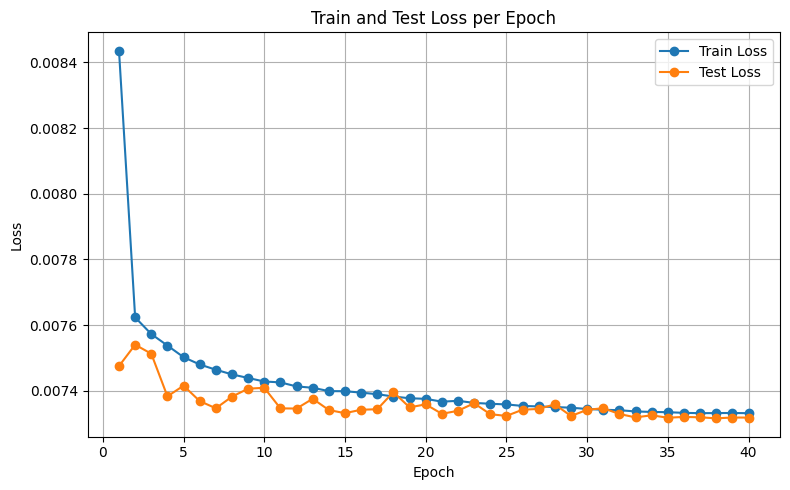

In [6]:
from matplotlib import pyplot as plt


epochs = range(1, len(train_losses) + 1)

# Построение графика
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, [loss.cpu() for loss in test_losses], label='Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
import os


notebook_name = "mlp"  # <-- измени на уникальное имя

# Создание папки, если её ещё нет
os.makedirs("loss", exist_ok=True)

# Сохраняем train_loss, test_loss и loss (если они существуют)
if 'train_losses' in globals():
    with open(f"loss/{notebook_name}_train_loss.json", "w") as f:
        json.dump(train_losses, f)

if 'test_losses' in globals():
    with open(f"loss/{notebook_name}_test_loss.json", "w") as f:
        json.dump([float(loss) for loss in test_losses], f)

In [4]:
total_loss = 0
total_batches = 0
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        vec = torch.cat((data['real'].x.view(-1), data['real'].edge_attr[:, 0], data['real'].edge_attr[:, 1]), dim=0)
        pred_alpha = model(vec)
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]
        scaled_f = y_scaler.inverse_transform([pred_f.cpu()])
        scaled_y = y_scaler.inverse_transform([data['real'].y.cpu()])
        scaled_f = torch.tensor(scaled_f, dtype=torch.float32)
        scaled_y = torch.tensor(scaled_y, dtype=torch.float32)
        batch_mae = mae_f(scaled_f, scaled_y)
        total_loss += batch_mae
        total_batches += 1
print(total_loss / total_batches)

tensor(649.1450)


In [5]:
total_loss = 0
total_batches = 0
from sklearn.metrics import mean_absolute_percentage_error

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        vec = torch.cat((data['real'].x.view(-1), data['real'].edge_attr[:, 0], data['real'].edge_attr[:, 1]), dim=0)
        pred_alpha = model(vec)
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]
        scaled_f = y_scaler.inverse_transform([pred_f.cpu()])
        scaled_y = y_scaler.inverse_transform([data['real'].y.cpu()])
        scaled_f = torch.tensor(scaled_f, dtype=torch.float32)
        scaled_y = torch.tensor(scaled_y, dtype=torch.float32)
        batch_mape = mean_absolute_percentage_error(scaled_f, scaled_y)
        total_loss += batch_mape
        total_batches += 1
print(total_loss / total_batches)


1.1379987006634473


In [6]:
import torch
from sklearn.metrics import mean_absolute_percentage_error

total_loss = 0
total_batches = 0

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        # Предсказания модели
        vec = torch.cat((data['real'].x.view(-1), data['real'].edge_attr[:, 0], data['real'].edge_attr[:, 1]), dim=0)
        pred_alpha = model(vec)
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]

        # Обратное масштабирование
        scaled_f = y_scaler.inverse_transform(pred_f.cpu().numpy().reshape(-1, 1)).flatten()
        scaled_y = y_scaler.inverse_transform(data['real'].y.cpu().numpy().reshape(-1, 1)).flatten()

        # Фильтрация ненулевых значений
        mask = scaled_y > 0
        if mask.sum() > 0:  # Проверка, есть ли ненулевые значения
            batch_mape = mean_absolute_percentage_error(scaled_y[mask], scaled_f[mask])
            total_loss += batch_mape
            total_batches += 1

# Усреднение MAPE по всем батчам
final_mape = total_loss / total_batches if total_batches > 0 else 0
print(f"Средний MAPE (без учета нулей): {final_mape:.4f}")


Средний MAPE (без учета нулей): 1.6539


In [7]:
total_loss = 0
total_batches = 0
from sklearn.metrics import mean_absolute_percentage_error

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        vec = torch.cat((data['real'].x.view(-1), data['real'].edge_attr[:, 0], data['real'].edge_attr[:, 1]), dim=0)
        pred_alpha = model(vec)
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]
        
        scaled_f = y_scaler.inverse_transform([pred_f.cpu()])
        scaled_y = y_scaler.inverse_transform([data['real'].y.cpu()])
        
        scaled_f = torch.tensor(scaled_f, dtype=torch.float32)
        scaled_y = torch.tensor(scaled_y, dtype=torch.float32)
        
        mask = scaled_y > 0
        if mask.any():
            batch_mape = mean_absolute_percentage_error(scaled_f[mask], scaled_y[mask])
            total_loss += batch_mape
            total_batches += 1
            
print(total_loss / total_batches if total_batches > 0 else 0)

1.1425918955504895


In [8]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

total_r2 = 0
total_batches = 0
true_values = []
pred_values = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        vec = torch.cat((data['real'].x.view(-1), data['real'].edge_attr[:, 0], data['real'].edge_attr[:, 1]), dim=0)
        pred_alpha = model(vec)
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]

        # Обратное преобразование с помощью scaler'а
        scaled_f = y_scaler.inverse_transform(pred_f.cpu().numpy().reshape(-1, 1)).flatten()
        scaled_y = y_scaler.inverse_transform(data['real'].y.cpu().numpy().reshape(-1, 1)).flatten()

        # Вычисление R^2
        batch_r2 = r2_score(scaled_y, scaled_f)
        total_r2 += batch_r2
        total_batches += 1

        # Добавляем в список для графика
        true_values.extend(scaled_y)
        pred_values.extend(scaled_f)

# Вычисляем средний R^2
avg_r2 = total_r2 / total_batches
print(f"Средний R²: {avg_r2:.4f}")

# Построение графика



Средний R²: 0.5104


In [9]:
from sklearn.metrics import mean_squared_error

total_loss = 0
total_batches = 0
true_values = []
pred_values = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        vec = torch.cat((data['real'].x.view(-1), data['real'].edge_attr[:, 0], data['real'].edge_attr[:, 1]), dim=0)
        pred_alpha = model(vec)
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]

        # Обратное преобразование через scaler
        scaled_f = y_scaler.inverse_transform(pred_f.cpu().numpy().reshape(-1, 1)).flatten()
        scaled_y = y_scaler.inverse_transform(data['real'].y.cpu().numpy().reshape(-1, 1)).flatten()

        # Сохраняем для MSE и графика
        true_values.extend(scaled_y)
        pred_values.extend(scaled_f)

# Вычисляем MSE
mse = mean_squared_error(true_values, pred_values)
print(f"MSE: {mse:.4f}")

MSE: 892365.6875


In [10]:
# import pickle
# import json
# model_name = "mlp"

# with open(f"scalers/node_scaler_{model}.pkl", "wb") as f:
#     pickle.dump(node_scaler, f)

# with open(f"scalers/edge_scaler_{model}.pkl", "wb") as f:
#     pickle.dump(edge_scaler, f)

# with open(f"scalers/y_scaler_{model}.pkl", "wb") as f:
#     pickle.dump(y_scaler, f)

# torch.save(model.state_dict(), f"models/hetgat_model_{model}.pth")

# with open(f"indicies/train_indices_{model}.json", "w") as f:
#     json.dump(train_indices, f)

# with open(f"indicies/test_indices_{model}.json", "w") as f:
#     json.dump(test_indices, f)


In [11]:
# import pickle
# import json
# model_name = "mlp_c"

# with open(f"scalers/node_scaler_{model_name}.pkl", "wb") as f:
#     pickle.dump(node_scaler, f)

# with open(f"scalers/edge_scaler_{model_name}.pkl", "wb") as f:
#     pickle.dump(edge_scaler, f)

# with open(f"scalers/y_scaler_{model_name}.pkl", "wb") as f:
#     pickle.dump(y_scaler, f)

# torch.save(model.state_dict(), f"models/hetgat_model_{model_name}.pth")

# with open(f"indices/train_indices_{model_name}.json", "w") as f:
#     json.dump(train_indices, f)

# with open(f"indices/test_indices_{model_name}.json", "w") as f:
#     json.dump(test_indices, f)

In [12]:
# import pickle
# import json
# model_name = "mlp_5_pairs"

# with open(f"scalers/node_scaler_{model_name}.pkl", "wb") as f:
#     pickle.dump(node_scaler, f)

# with open(f"scalers/edge_scaler_{model_name}.pkl", "wb") as f:
#     pickle.dump(edge_scaler, f)

# with open(f"scalers/y_scaler_{model_name}.pkl", "wb") as f:
#     pickle.dump(y_scaler, f)

# torch.save(model.state_dict(), f"models/hetgat_model_{model_name}.pth")

# with open(f"indices/train_indices_{model_name}.json", "w") as f:
#     json.dump(train_indices, f)

# with open(f"indices/test_indices_{model_name}.json", "w") as f:
#     json.dump(test_indices, f)
